# ANALISIS

In [3]:
import pandas as pd
from pandas.io import gbq
from google.cloud import bigquery
import os

credentials_path = 'D:/Henry/DATA-PF/PF-DATASCIENCE/Modelo/credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
#Cambiar limite de registros a conveniencia
#Change registry limit by convenience
limit = 1000000
sql1= f'''SELECT reviewerID, asin, reviewerName, overall FROM `SR.reviewLORD_reborn` LIMIT {limit} '''
df=pd.read_gbq(sql1,project_id="pf-henry-365404")

In [5]:
sql2="SELECT asin, title FROM SR.metaLORD"
df_title=pd.read_gbq(sql1,project_id="pf-henry-365404")

In [23]:
df

,reviewerID,asin,reviewerName,overall
0,A2LQLJWXQQM3PB,B00EYY6JHG,"Capt'n Bub ""seau2007""",1
1,AJGRTITJL7LTU,B00ENYLR8I,htmcs,1
2,ADNPIJY4C1OYU,B00I3MPDP4,"Bill ""I'm a Hispanic man who likes mostly non...",1
3,A3QEPSZ62L6BU5,B006Y5B2XE,Julius Weber,1
4,A5ORJWVHTBHFN,B0045B8FIO,Amazonologist,1
...,...,...,...,...
999995,A39ABKRS1MKFTW,0195170342,Cynthia K. Robertson,5
999996,A24MR3CENCQC53,0312424914,Erdajean,5
999997,A3D337LHR4JTEQ,1585670960,U. Sakoglu,5
999998,A2JO8RUJARRKQI,0312343140,Ben F. Small,5


In [24]:
# Usuarios únicos
# Uniquer users

print(len(df['reviewerID'].unique()))

486934


In [25]:
# Calificaciones de productos por usuario
# Products qualifications by user
df_by_users = df.groupby(['reviewerID']).count()
df_by_users.head()

,asin,reviewerName,overall
reviewerID,,,
A000443821AD43TOGKNGZ,2,2,2
A00046902LP5YSDV0VVNF,1,1,1
A000715434M800HLCENK9,2,2,2
A00085083TSCV82430YT4,2,2,2
A00097001C4CLB27DQV4U,1,1,1


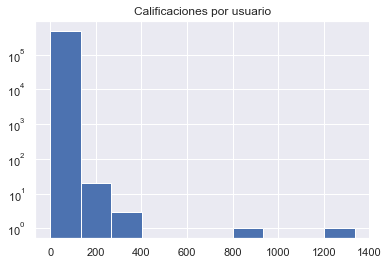

In [26]:
plt.hist(df_by_users.overall, log= True)
plt.title('Calificaciones por usuario')
plt.show()

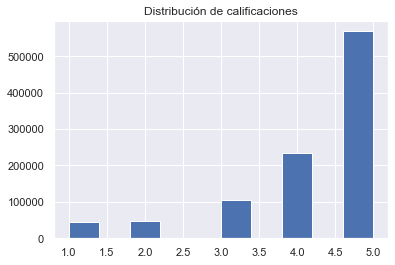

In [27]:
# Observamos la distribución de las calificaciones
df['overall'].hist()
plt.title('Distribución de calificaciones')
plt.show()

In [28]:
#Producto con mas calificaciones
#Most reviewed product
df_by_products = df.groupby(['asin']).count()
df_by_products.head()

,reviewerID,reviewerName,overall
asin,,,
0000031887,2,2,2
000100039X,9,9,9
0001055178,2,2,2
0001473123,1,1,1
0001473727,1,1,1


In [29]:
#Productos por popularidad
#Products by popularity
df_by_products = df.groupby(['asin']).count()
df_by_products.sort_values('reviewerID', ascending = False, inplace = True)
df_by_products['Vistos'] = df_by_products['reviewerID']
df_by_products.drop(columns = ['reviewerID','overall'], inplace = True)
df_by_products.head(10)

,reviewerName,Vistos
asin,,
030758836X,439,439
B00FAPF5U0,428,428
0439023483,383,383
B0086700CM,321,321
B00992CF6W,279,279
038536315X,269,269
0375831002,263,263
0439023513,253,253
B007WTAJTO,253,253


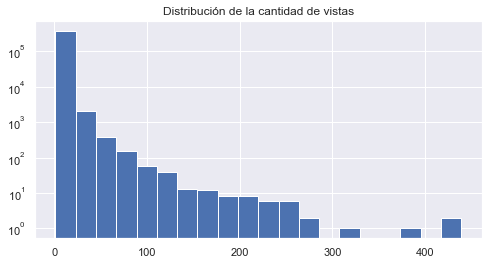

In [30]:
plt.figure(figsize = (8,4))

df_by_products.Vistos[df_by_products.Vistos<1000].hist(log = True, bins = 20)
plt.title('Distribución de la cantidad de vistas')

plt.show()

In [31]:
#Filtramos del dataset los productos con pocas calificaciones
#Filtering of the products with few reviews
umbral = 1000
mascara_pocos_vistos = df_by_products.Vistos<umbral

In [18]:
productos_pocos_vistos = mascara_pocos_vistos[mascara_pocos_vistos].index.values
print(len(productos_pocos_vistos), productos_pocos_vistos)

20 ['B000056J8N' 'B000056OUO' 'B004AMVVJI' 'B003IGTQWQ' 'B003D3NVUW'
 'B003BQ9JTI' 'B00384UZUU' 'B0030DFRGQ' 'B002SG7JGM' 'B001OMGDO0'
 'B001ABZGU2' 'B0016A7QYQ' 'B000O7SR18' 'B000O7SPUQ' 'B000NFJNLY'
 'B000KJBFC8' 'B000AV5LZ8' 'B000A32NP2' 'B00005BT37' 'B005VM62QS']


In [32]:
mascara_descartables = df.asin.isin(productos_pocos_vistos)

In [33]:
# Obsevamos cómo cambia la cantidad de registros a partir del filtrado

print(df.shape)
df = df[~mascara_descartables]
print(df.shape)

(1000000, 4)
(999918, 4)


# MODELADO

In [80]:
#Instanciamos el modelo
#Instance the model
import sys
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import dump


In [81]:
reader = Reader()

In [82]:
df.shape[0]

15740783

In [83]:

N_filas = df.shape[0] # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df[['reviewerName', 'asin', 'overall']][:N_filas], reader)

In [45]:
# Separamos nuestros datos
#Split the data
trainset, testset = train_test_split(data, test_size=.25)

In [84]:
trainset

In [85]:
# Usaremos un modelo de Singular Value Decomposition
from surprise import SVD
model = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.02)

In [86]:
# Entrenamos el modelo
#Training
model.fit(trainset)

In [87]:
# Predecimos
#Predict
predictions = model.test(testset)

In [50]:
predictions[1]

Prediction(uid='A1MVJPIKVCNP86', iid='B009934S5M', r_ui=1.0, est=3.598067442037955, details={'was_impossible': False})

In [51]:
model.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=4.233928816923716, details={'was_impossible': False})

In [88]:
# Tomaremos un usuario para hacerle una recomendación
#Lets take a user to do a recomendation
usuario = 'Amazon Customer'
rating = 4   

#Crea df que contiene todas las reseñas superiores a 4 estrellas del usuario indicado
#Creates df that contains all reviews with more than x ranting and that belongs to the user
df_user = df[(df['reviewerName'] == usuario) & (df['overall'] >= rating)]
df_user = df_user.reset_index(drop=True)

#Merge con titulos
#df_user = pd.merge(df_user,df_title['title'], on='productID')
#df_user['title'] = df_title['title'].loc[df_user['asin']].values
df_user = df_user.join(df_title.set_index('asin'), on='asin')
df_user

,reviewerName,asin,overall,title
0,Amazon Customer,B0099SMFVQ,4,Logitech Bluetooth Illuminated Keyboard K810 f...
1,Amazon Customer,B0098WV8F2,4,Bell Plantation PB2 Powdered Peanut Butter and...
2,Amazon Customer,B007QW5S3E,4,N/A
3,Amazon Customer,B004ISLNYC,4,N/A
4,Amazon Customer,B0050JKLW8,4,N/A
...,...,...,...,...
336997,Amazon Customer,1490547738,5,"Mad for You (Mad, Bad, &amp; Dangerous to Love..."
336998,Amazon Customer,0380728397,5,Don't Know Much About the Bible: Everything Yo...
336999,Amazon Customer,1493524208,5,"Royal Trouble: (Texas Trouble, #10)"
337000,Amazon Customer,014219672X,5,On the Island (Plume Book)


In [89]:
#Copia de title para recomendaciones
recomendaciones_usuario = df_title.copy()


In [90]:
# Debemos extraer los productos que ya ha comprado
# We must remove the bought products
usuario_vistas = df[df['reviewerName'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(409355, 3)


,reviewerName,asin,overall
95,Amazon Customer,0316037818,1
117,Amazon Customer,B005YDVGE2,1
218,Amazon Customer,B00CI9URW2,1
231,Amazon Customer,144235948X,1
258,Amazon Customer,B00FEM2XL8,1


In [152]:
recomendaciones_usuario

,title,asin
0,Sterling Silver Red Dark Amber Drop Pendant Ea...,B00D2RUK9Y
1,Harley-Davidson Men's Long Sleeve Screamin' Ea...,B00CQ49NLU
2,Circus by Sam Edelman Women's Gillian Boot,B00CPKZDQO
3,Ruby Red and Green Poinsettia Christmas Rosary...,B00CO9IM6E
4,Sterling Silver Native American Indian Feather...,B00CWGTCC2
...,...,...
9430083,N/A,0890982856
9430084,N/A,0966674006
9430085,N/A,0963317644
9430086,N/A,0966965671


In [91]:
# Sacamos las que filtramos
# Remove those we filtered
recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario.isin(productos_pocos_vistos).any(axis=1)]

In [154]:
recomendaciones_usuario

,title,asin
0,Sterling Silver Red Dark Amber Drop Pendant Ea...,B00D2RUK9Y
1,Harley-Davidson Men's Long Sleeve Screamin' Ea...,B00CQ49NLU
2,Circus by Sam Edelman Women's Gillian Boot,B00CPKZDQO
3,Ruby Red and Green Poinsettia Christmas Rosary...,B00CO9IM6E
4,Sterling Silver Native American Indian Feather...,B00CWGTCC2
...,...,...
9430083,N/A,0890982856
9430084,N/A,0966674006
9430085,N/A,0963317644
9430086,N/A,0966965671


In [92]:
#sacamos los productos reseñados por ese usuario

recomendaciones_usuario = recomendaciones_usuario[~(recomendaciones_usuario.asin.isin(usuario_vistas.asin))]
#recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,title,asin
0,Karen Kane Women's Plus-Size Stencil Dress,B00CSI12W2
1,Morgan Mesh Dress,B00D5XLYXG
2,Ashanti Sterling Silver Mint Green Amethyst Lo...,B00D2WUTE0
3,Akribos XXIV Women's AK567RG Impeccable Slim S...,B00DEX5LVI
4,School Uniform Unisex Short Sleeve Pique Knit ...,B00D3P4FY6


In [93]:
# Recomendamos
# Lets recomend
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['asin'].apply(lambda x: model.predict(usuario, x).est)

In [94]:
#Ordenamos las predicciones por puntuacion estimada
#Recomendations ordered by estimated score
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

                                                     title        asin  \
8813799                                                N/A  B00885RV9C   
6322590       9/11 - The Filmmakers' Commemorative Edition  B00006B1HI   
4098626                                        Ege Bamyasi  B0000067X3   
2629467                Coupling - The Complete Seasons 1-4  B0006HBLU0   
4478462                                     Out Of A Dream  B000006P8O   
6549331  The Coming of Conan the Cimmerian: The Origina...  0345461517   
5469561                                      Heaven's Fire  0451406990   
4569663                      Reba McEntire - Greatest Hits  B000002O42   
2232932         Panasonic BQ-CASE6SA Battery Storage Cases  B00JHKSKZQ   
8516983                                                N/A  B005DKRFV4   

         Estimate_Score  
8813799             5.0  
6322590             5.0  
4098626             5.0  
2629467             5.0  
4478462             5.0  
6549331             5.0  
546

In [98]:
import pandas as pd
from pandas.io import gbq
from google.cloud import bigquery
import os

credentials_path = 'D:/Henry/DATA-PF/PF-DATASCIENCE/Modelo/credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

In [100]:
#Exportamos la prediccion
#Export the prediction
recomendaciones_usuario.head(10).to_gbq(destination_table='SR.recomendaciones',project_id='pf-henry-365404',if_exists='append')

# EVALUACION

In [159]:
from surprise import accuracy
#Evaluamos matrices sobre las predicciones
#Evaluate accuracy rmse on the predictions
print('accuracy: ',accuracy.rmse(predictions))

RMSE: 0.9548
accuracy:  0.954843586213844


# OPTIMIZACION

In [128]:
from surprise.model_selection import cross_validate
#Realizamos validacion cruzada para optimizar N factores
#Run cross validacion for further optimization on N factors
rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9592  0.9593  0.9588  0.9591  0.0002  
Fit time          141.00  148.32  148.72  146.01  3.55    
Test time         54.63   52.02   61.67   56.11   4.07    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9591  0.9594  0.9589  0.9591  0.0002  
Fit time          147.65  148.89  149.45  148.66  0.75    
Test time         51.82   51.14   60.48   54.48   4.25    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9579  0.9599  0.9596  0.9591  0.0009  
Fit time          147.49  150.34  150.89  149.57  1.49    
Test time         53.33   50.89   59.04   54.42   3.41    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9595  0.9

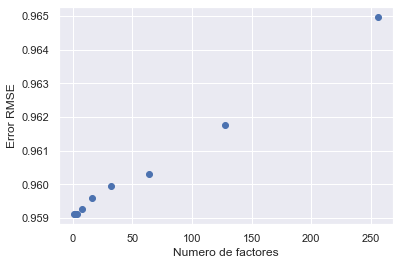

In [129]:
# Ploteamos desempeño según cantidad de factores de SVD
# Plot the rmse on all n factors
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [130]:
from surprise.model_selection import GridSearchCV
# Utilizamos gridsearch para optimizar mas los hiperparametros
# Go for optimization on more parameters with gridsearch
param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

c:\Users\gomez\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [131]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9591955534336384
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [133]:
len(predictions)

3935196

In [138]:
print(gs.best_score)

{'rmse': 0.9591955534336384}


In [ ]:
# Recopilamos todo para enviar a produccion
# Dump everything to production
dump.dump('./dump_SVD',predictions, model)